In [1]:
### Simulation parameters
n_donors = 2
n_conditions = 3
n_cells_per_donor_cond = 300
n_clones_in_don = 5
n_positions = 100
n_variants_per_clone_lambda = 1
n_donor_variants = 10

seq_error = 0.01
don_var_lim=(0.8,1)
clone_var_lim=(0.1,0.4)
depth_lim = (4,10)
chars = ["A", "G", "C", "T"]


outdir = "/data/Mito_Trace/output/clone_pileups_simulation/"
pileup_outdir = "data/MT/cellr_True/numread_200/"
ref_fa = "/data/Mito_Trace/data/processed/genomes/mtMasked/GRCh38_MT_blacklist_A2_2020/chrM.fasta"

In [2]:
from Bio import SeqIO

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from os.path import join, exists
import os
import matplotlib.pyplot as plt
np.random.seed(42)
%matplotlib inline


In [4]:
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=16)


INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:
if not exists(outdir):
    os.mkdir(outdir)

In [6]:
params = {"donors":n_donors,"conditions":n_conditions, "cells_per_donor_cond":n_cells_per_donor_cond,
         "clones_in_don":n_clones_in_don, "positions":n_positions, 
          "variants_per_clone_lambda":n_variants_per_clone_lambda, "donor_variants":n_donor_variants}


seq_params = {"seq_error": seq_error, "don_var_lim":"_".join(np.array(don_var_lim).astype(str)), 
              "clone_var_lim": "_".join(np.array(clone_var_lim).astype(str)),
             "depth_lim":"_".join(np.array(depth_lim).astype(str))}

curr_out_meta = ""
for p in params:
    curr_out_meta = f"{curr_out_meta}__{p}_{params[p]}"

curr_out_meta = curr_out_meta.strip("__")
print(curr_out_meta)


curr_out_seq = ""
for p in seq_params:
    curr_out_seq = f"{curr_out_seq}__{p}_{seq_params[p]}"
curr_out_seq = curr_out_seq.strip("__")
print(curr_out_seq)


curr_outdir = join(outdir, curr_out_meta, curr_out_seq)

if not exists(curr_outdir):
    os.makedirs(curr_outdir)

donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10
seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10


### Generate cells with donor and clone assignment

In [7]:
all_cells = []
for don in range(n_donors):
    for cond in range(n_conditions):
        clone_ids = np.random.choice(n_clones_in_don, size=n_cells_per_donor_cond)
        clone_names = [f"d{don}cl{cl_id}" for cl_id in clone_ids]
        #cell_names = [f"Cell_{i}_donor{don}_condition{cond}_clone{clone_names[i]}" for i in range(len(clone_ids))]
        cell_names = [f"Cell{i}donor{don}condition{cond}clone{clone_names[i]}" for i in range(len(clone_ids))]
        all_cells.append(pd.DataFrame({"donor": don, "condition": cond, 
                                       "clone": [f"{nm}" for nm in clone_names]}, index=cell_names))

all_cells_df = pd.concat(all_cells, axis=0, verify_integrity=True)
all_cells_df



,donor,condition,clone
Cell0donor0condition0cloned0cl3,0,0,d0cl3
Cell1donor0condition0cloned0cl4,0,0,d0cl4
Cell2donor0condition0cloned0cl2,0,0,d0cl2
Cell3donor0condition0cloned0cl4,0,0,d0cl4
Cell4donor0condition0cloned0cl4,0,0,d0cl4
...,...,...,...
Cell295donor1condition2cloned1cl4,1,2,d1cl4
Cell296donor1condition2cloned1cl2,1,2,d1cl2
Cell297donor1condition2cloned1cl4,1,2,d1cl4
Cell298donor1condition2cloned1cl0,1,2,d1cl0


### Generate clone meta with ncells, do for condition and groupby it

In [8]:
# Make clones_meta_cond_df and clones_meta_df
clones_meta_cond_df = all_cells_df.groupby(["clone", "condition", "donor"]).size().to_frame('ncells').reset_index()
clones_meta_cond_df

,clone,condition,donor,ncells
0,d0cl0,0,0,69
1,d0cl0,1,0,58
2,d0cl0,2,0,65
3,d0cl1,0,0,46
4,d0cl1,1,0,65
5,d0cl1,2,0,63
6,d0cl2,0,0,63
7,d0cl2,1,0,44
8,d0cl2,2,0,59
9,d0cl3,0,0,74


In [9]:
clones_meta_df = clones_meta_cond_df.groupby(["clone", "donor"]).sum()["ncells"].to_frame("ncells").reset_index()
clones_meta_df

,clone,donor,ncells
0,d0cl0,0,192
1,d0cl1,0,174
2,d0cl2,0,166
3,d0cl3,0,187
4,d0cl4,0,181
5,d1cl0,1,183
6,d1cl1,1,178
7,d1cl2,1,181
8,d1cl3,1,171
9,d1cl4,1,187


## Plot the number of cells

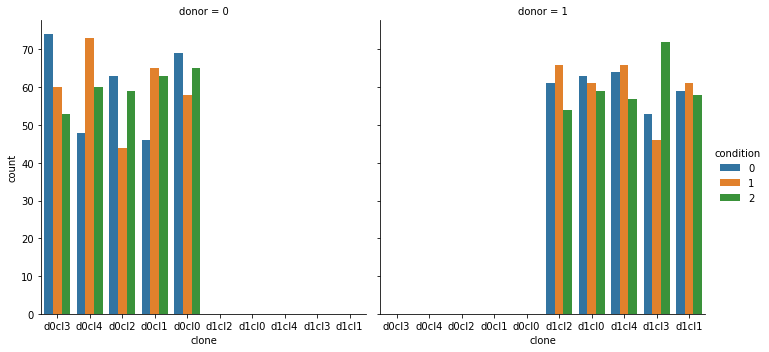

In [10]:
g = sns.catplot(data=all_cells_df.astype(str), x="clone", col="donor", hue="condition", kind="count")

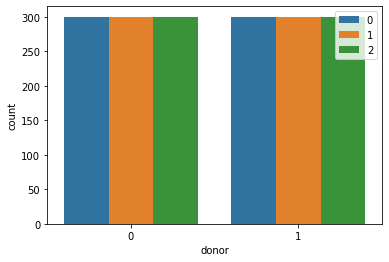

In [11]:
g = sns.countplot(data=all_cells_df.astype(str),x="donor", hue="condition")

plt.legend()

# Get the variant assignments for donor and clone

## make a reference (1-based)

In [12]:
#ref_char = np.random.choice(chars, n_positions)
ref_char = list(str(SeqIO.to_dict(SeqIO.parse(ref_fa, "fasta"))["chrM"].seq))

ref = [f"{i+1}_{c}" for i, c in enumerate(ref_char)]

ref_df = pd.DataFrame(np.array([range(1,1+len(ref_char)),ref_char]).transpose(),index=ref, columns=["pos", "ref"])
ref_df.head()

,pos,ref
1_G,1,G
2_A,2,A
3_T,3,T
4_C,4,C
5_A,5,A


## Donor variants

In [13]:
don_vars = []
for d in range(n_donors):
    curr_ref_vars = np.random.choice(ref_df.index.values, replace=False, size=n_donor_variants)
    # Pick variant not from reference
    curr_alt = [np.random.choice(list(set(chars)-set([ref_df.loc[x,"ref"]]))) for x in curr_ref_vars]
    curr_ref = [ref_df.loc[x,"ref"] for x in curr_ref_vars]
    curr_pos = [ref_df.loc[x,"pos"] for x in curr_ref_vars]
    
    # Setup donor variant df
    curr_v_df = pd.DataFrame(data=np.array([curr_alt,curr_ref_vars]).transpose(), 
                             index=curr_ref_vars, columns=["alt", "ref_id"])
    curr_v_df["ref"] = curr_ref
    curr_v_df["pos"] = curr_pos
    curr_v_df["donor"] = d
    curr_v_df.index = curr_v_df["ref_id"]+"_"+curr_v_df["donor"].astype(str)

    don_vars.append(curr_v_df)


don_vars_df = pd.concat(don_vars, verify_integrity=True)
don_vars_df

,alt,ref_id,ref,pos,donor
11719_G_0,A,11719_G,G,11719,0
14350_C_0,G,14350_C,C,14350,0
9528_C_0,G,9528_C,C,9528,0
12833_C_0,T,12833_C,C,12833,0
5767_C_0,T,5767_C,C,5767,0
12920_C_0,G,12920_C,C,12920,0
1558_A_0,G,1558_A,A,1558,0
11150_G_0,T,11150_G,G,11150,0
4832_C_0,A,4832_C,C,4832,0
8953_A_0,G,8953_A,A,8953,0


## Clone variants

In [14]:
clone_vars = []
for ind, val in clones_meta_df.iterrows():
    ## Generate clone-specific cars
    # a. number of variants using lamba
    num_vars = np.random.poisson(lam=1)+1
    
    # b. get positions, not from donor
    curr_don_ref = don_vars_df.loc[val["donor"]==don_vars_df["donor"], "ref_id"].values
    
    # c. Continue as with donor
    curr_ref_vars = np.random.choice(ref_df.index.drop(curr_don_ref), replace=False, size=num_vars)
    
    # Pick variant not from reference
    curr_alt = [np.random.choice(list(set(chars)-set([ref_df.loc[x,"ref"]]))) for x in curr_ref_vars]
    curr_ref = [ref_df.loc[x,"ref"] for x in curr_ref_vars]
    curr_pos = [ref_df.loc[x,"pos"] for x in curr_ref_vars]
    
    # Setup clone variant df
    curr_v_df = pd.DataFrame(data=np.array([curr_pos, curr_ref, curr_alt, curr_ref_vars]).transpose(), 
                             index=curr_ref_vars, columns=[ "pos", "ref", "alt", "ref_id"])
    curr_v_df["donor"] = val["donor"]
    curr_v_df["clone"] = val["clone"]
    curr_v_df.index = curr_v_df["ref_id"]+">"+curr_v_df["alt"]+"_"+curr_v_df["donor"].astype(str) + "_" +curr_v_df["clone"].astype(str)

    clone_vars.append(curr_v_df)


clone_vars_df = pd.concat(clone_vars, verify_integrity=True)
clone_vars_df

,pos,ref,alt,ref_id,donor,clone
7369_C>T_0_d0cl0,7369,C,T,7369_C,0,d0cl0
6842_T>A_0_d0cl0,6842,T,A,6842_T,0,d0cl0
7151_C>T_0_d0cl1,7151,C,T,7151_C,0,d0cl1
15306_T>G_0_d0cl1,15306,T,G,15306_T,0,d0cl1
4225_A>C_0_d0cl2,4225,A,C,4225_A,0,d0cl2
2841_T>C_0_d0cl2,2841,T,C,2841_T,0,d0cl2
5663_C>G_0_d0cl2,5663,C,G,5663_C,0,d0cl2
2549_C>A_0_d0cl3,2549,C,A,2549_C,0,d0cl3
1972_A>G_0_d0cl3,1972,A,G,1972_A,0,d0cl3
15378_T>A_0_d0cl3,15378,T,A,15378_T,0,d0cl3


In [15]:
print("Positions seen multiple times in a donor")
curr = clone_vars_df.groupby(["ref_id", "donor"]).size()
(curr[curr>1])

Positions seen multiple times in a donor


Series([], dtype: int64)

## Add variant that has same position but different reference

In [16]:
# print(don_vars_df.shape)
# don_vars_df.head()

# donors=list(set(don_vars_df["donor"].values))
# n_same_pos_vars = 2
# for i in range(n_same_pos_vars):
#     curr = don_vars_df.iloc[i]
#     new = curr.copy()
#     new["alt"] = np.random.choice(list(set(chars)-set([curr["alt"], curr["ref"]])))
#     new["donor"] = np.random.choice(donors)
#     new.name = f"{new['pos']}_{new['ref']}_{new['alt']}"
#     don_vars_df = don_vars_df.append(new)


# print(don_vars_df.shape)
# don_vars_df.tail()

# print(clone_vars_df.shape)
# clone_vars_df.tail()

# clone_vars_df.head()

# n_same_pos_vars = 3
# for i in range(n_same_pos_vars):
#     curr = clone_vars_df.iloc[i]
#     new = curr.copy()
#     new["alt"] = np.random.choice(list(set(chars)-set([curr["alt"], curr["ref"]])))
#     new["clone"] = np.random.choice(list(set(clone_vars_df["clone"].values)-set([curr["clone"]])), size=1)[0]
#     new["donor"] = new["clone"].split("_")[0][1:]
#     new.name = new["ref_id"]+">"+new["alt"]+ "_" +new["clone"]
#     #new.name = f"{new['pos']}_{new['ref']}_{new['alt']}"
#     clone_vars_df = clone_vars_df.append(new)
    
# new

# print(clone_vars_df.shape)
# clone_vars_df.tail()


# Add pileups with no 

In [17]:
#clone_vars_df = pd.DataFrame(index=clone_meta_df.index, columns = [np.random.choice(n_positions)])

## For each cell generate pileup matrix for each nucleotide.
so cell1_A_df: [Pos_count, Neg_count, BQ]

parameters needed:  
- seq_error (0.001)  
- depth distribution log2(uniform(2,10))
- strand_assign: binomial(0.5)
- base quality average: constant of 30- all of them pass

In [18]:
from collections import Counter

In [19]:
counts = pd.DataFrame({"counts":np.floor(2**(np.random.randint(2,10, size=ref_df.shape[0]))),
                      "ref":ref_df["ref"], "pos":ref_df["pos"],
                      "ref_id":ref_df.index},
                      index=ref_df.index)
counts["counts"] = counts["counts"].astype(int)
counts

,counts,ref,pos,ref_id
1_G,64,G,1,1_G
2_A,32,A,2,2_A
3_T,512,T,3,3_T
4_C,256,C,4,4_C
5_A,8,A,5,5_A
...,...,...,...,...
16565_C,16,C,16565,16565_C
16566_G,4,G,16566,16566_G
16567_A,16,A,16567,16567_A
16568_T,4,T,16568,16568_T


In [20]:
def generate_nonspec_vars(cell_ser, cell_nm, seq_err=0.001, chars=["A","C","G","T"]):
#    print(cell_ser)
    reads = cell_ser["counts"]
    ref = cell_ser["ref"]
    ref_id = cell_ser["ref_id"]
    seq_err_counts = np.random.binomial(reads,seq_err)
    oth_nts = list(set(chars)-set([ref]))
    out = {}
    if seq_err_counts>0:
        # Change the nt to the non alt allele
        out = Counter(np.random.choice(oth_nts, size=seq_err_counts,replace=True))
    else:
        out  = {x:0 for x in oth_nts}
    out[ref] = reads - seq_err_counts

    out["pos"] = cell_ser["pos"]
    out["cell"] = cell_nm
    
    return pd.Series(out)

def cell_nonspec_variants(curr_counts, cell_name):
    curr_cell_pile = curr_counts.apply(generate_nonspec_vars, args=(cell_name,), axis=1).reset_index().rename({"index":"ref_id"},axis=1)
    curr_cell_pile = curr_cell_pile.drop("ref_id",axis=1).melt(id_vars=["pos", "cell"], value_name="counts", var_name="nt")
    curr_cell_pile = (curr_cell_pile.loc[curr_cell_pile["counts"]!=0]).dropna()
    return curr_cell_pile

def generate_specific_vars(d_v_ser,  cell_nm, don_var_lim, seq_err=0.001, chars=["A","C","G","T"]):
    #out = {}  
    reads = d_v_ser["counts"]
    ref = d_v_ser["ref"]
    alt = d_v_ser["alt"]
    pos = d_v_ser["pos"]
    ref_id = d_v_ser["ref_id"] 
    
    curr_af = np.random.uniform(don_var_lim[0],don_var_lim[1]) # generate using uniform distribution
    curr_af_counts = int(np.floor(curr_af*reads))
    #curr_af_counts = int(np.floor(curr_af*counts.loc[ref_id, "counts" ]))
    
    seq_err_counts = np.random.binomial(reads,seq_err)
    
    
    oth_nts = list(set(chars)-set([alt, ref]))
    if seq_err_counts>0:
        # Change the nt to the non alt allele
        out = Counter(np.random.choice(oth_nts, size=seq_err_counts,replace=True))
    else:
        out  = {x:0 for x in oth_nts}
        
    # Add in the reference and alt counts!
    out[alt] = reads - seq_err_counts
    out[ref] = max(reads - curr_af_counts - seq_err_counts,0)
    out["pos"] = d_v_ser["pos"]
    out["cell"] = cell_nm
    
    # Add the reference counts
    
    return pd.Series(out)

def cell_donor_variants(curr_cell_counts, cell_name, don_var_lim):
    """ Generates cell's donor variant counts based on the donor variant limits.
    """
    curr_cell_pile = curr_cell_counts.apply(generate_specific_vars, args=(cell_name,don_var_lim), axis=1).reset_index().rename({"index":"ref_id"},axis=1)
#     print('curr_cell_pile')
#     print(curr_cell_pile.head())
   # print(curr_cell_pile)
    curr_cell_pile = curr_cell_pile.drop("ref_id",axis=1).melt(id_vars=["pos", "cell"], value_name="counts", var_name="nt")
    curr_cell_pile = (curr_cell_pile.loc[curr_cell_pile["counts"]!=0]).dropna()
    return curr_cell_pile

def cell_clone_variants(curr_cell_counts, cell_name, clone_var_lim):
    """ Generates cell's counts based on the clone limits.
    """
    curr_cell_pile = curr_cell_counts.apply(generate_specific_vars, args=(cell_name,clone_var_lim), axis=1).reset_index().rename({"index":"ref_id"},axis=1)
    curr_cell_pile = curr_cell_pile.drop("ref_id",axis=1).melt(id_vars=["pos", "cell"], value_name="counts", var_name="nt")
    curr_cell_pile = (curr_cell_pile.loc[curr_cell_pile["counts"]!=0]).dropna()
    return curr_cell_pile


In [21]:
def cell_variants(cell_ser, ref_df, don_vars_df, clone_vars_df, seq_err=0.001, depth_lim=(2,10), strand_bin=0.5,
                 don_var_lim=(0.8,1), clone_var_lim=(0.1,0.5)):
    #cell_pileups = {}
    curr_clone = cell_ser["clone"]
    curr_don = cell_ser["donor"]
    cell_name = cell_ser.name
    
    # Get the donor and clone variants
    curr_don_vars = don_vars_df.loc[don_vars_df["donor"]==curr_don].set_index("ref_id")
    curr_cl_vars = clone_vars_df.loc[clone_vars_df["clone"]==curr_clone].set_index("ref_id")
    
    # Generate counts at each position
    counts = pd.DataFrame({"counts":np.floor(2**(np.random.randint(2,10, size=ref_df.shape[0]))),
                      "ref":ref_df["ref"], "pos":ref_df["pos"],
                      "ref_id":ref_df.index, "cell": cell_name},
                      index=ref_df.index)
    counts["counts"] = counts["counts"].astype(int)
    
    # Non-donor and non-clone vars
    #print('non-spec counts')
#     print('don vars', curr_don_vars.index)
#     print('clone vars', curr_cl_vars.index)
    non_spec_counts = counts.drop(curr_don_vars.index).drop(curr_cl_vars.index)
    non_spec_pileup = cell_nonspec_variants(non_spec_counts, cell_name)

    #print('don spec')
    # First construct donor variants
    cell_donSpec_counts = counts.loc[curr_don_vars.index]
    cell_donSpec_counts["alt"] = curr_don_vars["alt"]
    cell_donSpec_pileup = cell_donor_variants(cell_donSpec_counts, cell_name, don_var_lim)

    #print('clone spec')
    # Construct clone variants
    cell_cloneSpec_counts = counts.loc[curr_cl_vars.index]
    cell_cloneSpec_counts["alt"] = curr_cl_vars["alt"]
    cell_cloneSpec_pileup = cell_clone_variants(cell_cloneSpec_counts, cell_name, clone_var_lim)
    
#     for d_v in curr_don_vars:
#         curr_don_pileup = {}
#         curr_ref = curr_don_vars.loc[d_v, "ref"]
#         curr_alt = curr_don_vars.loc[d_v, "alt"]
#         curr_pos = curr_don_vars.loc[d_v, "pos"]
#         curr_ref_id = curr_don_vars.loc[d_v, "ref_id"] 
#         curr_af = np.random.uniform(clone_var_lim[0],clone_var_lim[1])
#         curr_af_counts = int(np.floor(curr_af*counts.loc[curr_ref_id, "counts" ]))
#         seq_err_counts = np.random.binomial(counts.loc[curr_ref_id, "counts"],seq_err)
#         curr_af_counts -= seq_err_counts
#         if len(seq_error_counts)>0:
#             # Change the nt to the non alt allele
#             seq_err_counts = Counter(np.random.choice(set(chars)-set([curr_alt]), size=seq_err_counts,replace=True))
            
        

#     print(cell_donSpec_counts.head())
#     print(cell_cloneSpec_counts.head())
#     print(non_spec.head())

    # concat donor-, clone-, and non-specific pileup dfs
    out_df = pd.concat([cell_donSpec_pileup, cell_cloneSpec_pileup, non_spec_pileup], axis=0)
    out_df["donor"] = cell_ser["donor"]
    out_df["condition"] = cell_ser["condition"]
    return out_df


## For each cell, generate a 'pileup df', which contains read depth at each position
The columns are ["pos","cell","nt","counts","donor","condition"]

In [22]:
pileups_all = all_cells_df.parallel_apply(cell_variants, 
                               args=(ref_df, don_vars_df, clone_vars_df, seq_error, depth_lim, 0.5, 
                                     don_var_lim, clone_var_lim), axis=1)

pileups_df = pd.concat(pileups_all.values)

In [23]:
# pileups_all = all_cells_df.apply(cell_variants, 
#                                  args=(ref_df, don_vars_df, clone_vars_df, seq_error, depth_lim, 0.5, 
#                                  don_var_lim, clone_var_lim), axis=1)

# pileups_df = pd.concat(pileups_all.values)

In [24]:
pileups_df["clone"] = pileups_df["cell"].apply(lambda x: x.split("cl")[-1]).astype(int)

In [25]:
(pileups_df["donor"]==0) & (pileups_df["clone"]==0)

0        False
6        False
8        False
9        False
11       False
         ...  
82770    False
82771    False
82775    False
82782    False
82788    False
Length: 33441028, dtype: bool

In [26]:
pileups_df[(pileups_df["donor"]==0) & (pileups_df["clone"]==0) & (pileups_df["pos"]=="67")].sort_values(["cell", "pos", "counts"])

,pos,cell,nt,counts,donor,condition,clone
33180,67,Cell101donor0condition0cloned0cl0,G,32.0,0,0,0
33180,67,Cell102donor0condition1cloned0cl0,G,4.0,0,1,0
33180,67,Cell104donor0condition0cloned0cl0,G,256.0,0,0,0
33180,67,Cell104donor0condition2cloned0cl0,G,256.0,0,2,0
33180,67,Cell106donor0condition1cloned0cl0,G,512.0,0,1,0
...,...,...,...,...,...,...,...
33180,67,Cell94donor0condition0cloned0cl0,G,16.0,0,0,0
66,67,Cell94donor0condition2cloned0cl0,A,1.0,0,2,0
33180,67,Cell94donor0condition2cloned0cl0,G,511.0,0,2,0
33180,67,Cell99donor0condition0cloned0cl0,G,64.0,0,0,0


## Checks


### clone variant 

In [27]:
pileups_df[(pileups_df["donor"]==0)
           & (pileups_df["clone"]==0)
           & (pileups_df["pos"]=="67")].sort_values(["cell", "pos", "counts"])

,pos,cell,nt,counts,donor,condition,clone
33180,67,Cell101donor0condition0cloned0cl0,G,32.0,0,0,0
33180,67,Cell102donor0condition1cloned0cl0,G,4.0,0,1,0
33180,67,Cell104donor0condition0cloned0cl0,G,256.0,0,0,0
33180,67,Cell104donor0condition2cloned0cl0,G,256.0,0,2,0
33180,67,Cell106donor0condition1cloned0cl0,G,512.0,0,1,0
...,...,...,...,...,...,...,...
33180,67,Cell94donor0condition0cloned0cl0,G,16.0,0,0,0
66,67,Cell94donor0condition2cloned0cl0,A,1.0,0,2,0
33180,67,Cell94donor0condition2cloned0cl0,G,511.0,0,2,0
33180,67,Cell99donor0condition0cloned0cl0,G,64.0,0,0,0


#### non ref or alt (seq_error) for same clone

In [28]:
pileups_df[(pileups_df["donor"]==0)
           & (pileups_df["clone"]==0)
           & (~pileups_df["nt"].isin(["A","T"]))
           & (pileups_df["pos"]=="67")].sort_values(["cell", "pos", "counts"])

,pos,cell,nt,counts,donor,condition,clone
33180,67,Cell101donor0condition0cloned0cl0,G,32.0,0,0,0
33180,67,Cell102donor0condition1cloned0cl0,G,4.0,0,1,0
33180,67,Cell104donor0condition0cloned0cl0,G,256.0,0,0,0
33180,67,Cell104donor0condition2cloned0cl0,G,256.0,0,2,0
33180,67,Cell106donor0condition1cloned0cl0,G,512.0,0,1,0
...,...,...,...,...,...,...,...
33180,67,Cell93donor0condition2cloned0cl0,G,4.0,0,2,0
33180,67,Cell94donor0condition0cloned0cl0,G,16.0,0,0,0
33180,67,Cell94donor0condition2cloned0cl0,G,511.0,0,2,0
33180,67,Cell99donor0condition0cloned0cl0,G,64.0,0,0,0


### non-clone variant

In [29]:
pileups_df[(pileups_df["donor"]==0)
           & (pileups_df["clone"]==0)
           & (pileups_df["pos"]=="68")].sort_values(["cell", "pos", "counts"])

,pos,cell,nt,counts,donor,condition,clone
33181,68,Cell101donor0condition0cloned0cl0,G,16.0,0,0,0
33181,68,Cell102donor0condition1cloned0cl0,G,64.0,0,1,0
33181,68,Cell104donor0condition0cloned0cl0,G,4.0,0,0,0
33181,68,Cell104donor0condition2cloned0cl0,G,128.0,0,2,0
33181,68,Cell106donor0condition1cloned0cl0,G,256.0,0,1,0
...,...,...,...,...,...,...,...
33181,68,Cell93donor0condition2cloned0cl0,G,128.0,0,2,0
33181,68,Cell94donor0condition0cloned0cl0,G,4.0,0,0,0
33181,68,Cell94donor0condition2cloned0cl0,G,64.0,0,2,0
33181,68,Cell99donor0condition0cloned0cl0,G,8.0,0,0,0


#### non-clone variant non-ref alleles

In [30]:
pileups_df[(pileups_df["donor"]==0)
           & (pileups_df["clone"]==0)
           & (~pileups_df["nt"].isin(["A"]))
           & (pileups_df["pos"]=="68")].sort_values(["cell", "pos", "counts"])

,pos,cell,nt,counts,donor,condition,clone
33181,68,Cell101donor0condition0cloned0cl0,G,16.0,0,0,0
33181,68,Cell102donor0condition1cloned0cl0,G,64.0,0,1,0
33181,68,Cell104donor0condition0cloned0cl0,G,4.0,0,0,0
33181,68,Cell104donor0condition2cloned0cl0,G,128.0,0,2,0
33181,68,Cell106donor0condition1cloned0cl0,G,256.0,0,1,0
...,...,...,...,...,...,...,...
33181,68,Cell93donor0condition2cloned0cl0,G,128.0,0,2,0
33181,68,Cell94donor0condition0cloned0cl0,G,4.0,0,0,0
33181,68,Cell94donor0condition2cloned0cl0,G,64.0,0,2,0
33181,68,Cell99donor0condition0cloned0cl0,G,8.0,0,0,0


## Add BQ and strand. Pick strand from binomial

In [31]:
def split_strand(ser):
    counts = ser["counts"]
     
    pos = np.random.binomial(counts, 0.5)
    neg = counts-pos
    
#     pos_ser = ser.copy()
#     pos_ser["counts"] = pos
#     pos_ser["strand"] = "+"
#     neg_ser = ser.copy()
#     neg_ser["counts"] = neg
#     neg_ser["strand"] = "-"
    
    ser["Count Fw"] = pos
    ser["Count Rev"] = neg
    return ser
    #return pd.concat([pd.DataFrame(pos_tmp),pd.DataFrame(neg_tmp)], axis=1, ignore_index=True).transpose()

In [32]:
pileups_df_strand = pileups_df.parallel_apply(split_strand, axis=1)
pileups_df_strand

,pos,cell,nt,counts,donor,condition,clone,Count Fw,Count Rev
0,11719,Cell0donor0condition0cloned0cl3,A,16.0,0,0,3,3,13.0
6,1558,Cell0donor0condition0cloned0cl3,A,2.0,0,0,3,2,0.0
8,4832,Cell0donor0condition0cloned0cl3,A,4.0,0,0,3,2,2.0
9,8953,Cell0donor0condition0cloned0cl3,A,3.0,0,0,3,2,1.0
11,14350,Cell0donor0condition0cloned0cl3,C,1.0,0,0,3,1,0.0
...,...,...,...,...,...,...,...,...,...
82770,16550,Cell299donor1condition2cloned1cl0,T,16.0,1,2,0,9,7.0
82771,16551,Cell299donor1condition2cloned1cl0,T,31.0,1,2,0,20,11.0
82775,16555,Cell299donor1condition2cloned1cl0,T,4.0,1,2,0,2,2.0
82782,16562,Cell299donor1condition2cloned1cl0,T,128.0,1,2,0,59,69.0


In [33]:
pileups_df_strand["BQ Fw"] = 37
pileups_df_strand["BQ Rev"] = 37

pileups_df_strand["BQ Fw"] = pileups_df_strand["BQ Fw"].astype(int)
pileups_df_strand["BQ Rev"] = pileups_df_strand["BQ Rev"].astype(int)

In [34]:
pileups_df[pileups_df["counts"]<=0]

,pos,cell,nt,counts,donor,condition,clone


In [35]:
pileups_df_strand["Count Rev"] = pileups_df_strand["Count Rev"].astype(int)
pileups_df_strand["Count Fw"] = pileups_df_strand["Count Fw"].astype(int)

pileups_df_strand["pos"] = pileups_df_strand["pos"].astype(int)

In [36]:
pileups_df_strand.head()

,pos,cell,nt,counts,donor,condition,clone,Count Fw,Count Rev,BQ Fw,BQ Rev
0,11719,Cell0donor0condition0cloned0cl3,A,16.0,0,0,3,3,13,37,37
6,1558,Cell0donor0condition0cloned0cl3,A,2.0,0,0,3,2,0,37,37
8,4832,Cell0donor0condition0cloned0cl3,A,4.0,0,0,3,2,2,37,37
9,8953,Cell0donor0condition0cloned0cl3,A,3.0,0,0,3,2,1,37,37
11,14350,Cell0donor0condition0cloned0cl3,C,1.0,0,0,3,1,0,37,37


In [37]:
# print(don_vars_df.shape)
# don_vars_df.head()

# donors=list(set(don_vars_df["donor"].values))
# n_same_pos_vars = 2
# for i in range(n_same_pos_vars):
#     curr = don_vars_df.iloc[i]
#     new = curr.copy()
#     new["alt"] = np.random.choice(list(set(chars)-set([curr["alt"], curr["ref"]])))
#     new["donor"] = np.random.choice(donors)
#     new.name = f"{new['pos']}_{new['ref']}_{new['alt']}"
#     don_vars_df = don_vars_df.append(new)


# print(don_vars_df.shape)
# don_vars_df.tail()

# print(clone_vars_df.shape)
# clone_vars_df.tail()

# clone_vars_df.head()

# n_same_pos_vars = 3
# for i in range(n_same_pos_vars):
#     curr = clone_vars_df.iloc[i]
#     new = curr.copy()
#     new["alt"] = np.random.choice(list(set(chars)-set([curr["alt"], curr["ref"]])))
#     new["clone"] = np.random.choice(list(set(clone_vars_df["clone"].values)-set([curr["clone"]])), size=1)[0]
#     new["donor"] = new["clone"].split("_")[0][1:]
#     new.name = new["ref_id"]+">"+new["alt"]+ "_" +new["clone"]
#     #new.name = f"{new['pos']}_{new['ref']}_{new['alt']}"
#     clone_vars_df = clone_vars_df.append(new)
    
# new

# print(clone_vars_df.shape)
# clone_vars_df.tail()


# Add pileups with no 
# n_same_pos_vars = 3
# for i in range(n_same_pos_vars):
#     curr = clone_vars_df.iloc[i]
#     new = curr.copy()
#     new["alt"] = np.random.choice(list(set(chars)-set([curr["alt"], curr["ref"]])))
#     new["clone"] = np.random.choice(list(set(clone_vars_df["clone"].values)-set([curr["clone"]])), size=1)[0]
#     new["donor"] = new["clone"].split("_")[0][1:]
#     new.name = new["ref_id"]+">"+new["alt"]+ "_" +new["clone"]
#     #new.name = f"{new['pos']}_{new['ref']}_{new['alt']}"
#     clone_vars_df = clone_vars_df.append(new)

    # adjust the counts
    # pileups_df_strand[(pileups_df_strand["pos"] == curr["pos"]) & ()]
    # Adjust the af values 
    
# new
# n_same_pos_vars = 3
# for i in range(n_same_pos_vars):
#     curr = clone_vars_df.iloc[i]
#     new = curr.copy()
#     new["alt"] = np.random.choice(list(set(chars)-set([curr["alt"], curr["ref"]])))
#     new["clone"] = np.random.choice(list(set(clone_vars_df["clone"].values)-set([curr["clone"]])), size=1)[0]
#     new["donor"] = new["clone"].split("_")[0][1:]
#     new.name = new["ref_id"]+">"+new["alt"]+ "_" +new["clone"]
#     #new.name = f"{new['pos']}_{new['ref']}_{new['alt']}"
#     clone_vars_df = clone_vars_df.append(new)


## Save pileups

In [38]:
## Convert to nt's
for (nt, cond), curr_out_df in pileups_df_strand.groupby(["nt", "condition"]):
    cond_outdir = join(curr_outdir, f"cond{cond}", pileup_outdir)
    print(cond_outdir)
    if not exists(cond_outdir):
        os.makedirs(cond_outdir)
    print(nt,cond)
    curr_out_df[["pos","cell","Count Fw","BQ Fw","Count Rev","BQ Rev"]].sort_values(["cell", "pos", "Count Fw"]).to_csv(join(cond_outdir, f"cond{cond}.{nt}.strands.txt"), 
                                                                               header=None, index=None)
    #curr_out.to_csv(join(outdir, f"cond{cond}.{nt}.strands.txt.gz"), compression='gzip')

/data/Mito_Trace/output/clone_pileups_simulation/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10/seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10/cond0/data/MT/cellr_True/numread_200/
A 0
/data/Mito_Trace/output/clone_pileups_simulation/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10/seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10/cond1/data/MT/cellr_True/numread_200/
A 1
/data/Mito_Trace/output/clone_pileups_simulation/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10/seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10/cond2/data/MT/cellr_True/numread_200/
A 2
/data/Mito_Trace/output/clone_pileups_simulation/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5_

## total coverage

In [ ]:
for cond, curr_out_df in pileups_df_strand.groupby("condition"):
    coverage = curr_out_df.groupby(["cell", "pos"]).parallel_apply(lambda x: (x["Count Rev"]+x["Count Fw"]).sum()).reset_index()
    cond_outdir = join(curr_outdir, f"cond{cond}", pileup_outdir)
    print(cond_outdir)
    coverage["pos"] = coverage["pos"].astype(int)
    coverage[["pos","cell",0]].sort_values(["cell","pos"]).to_csv(join(cond_outdir, f"cond{cond}.coverage.strands.txt"), 
                                                                               header=None, index=None) #compression='gzip')


/data/Mito_Trace/output/clone_pileups_simulation/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10/seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10/cond0/data/MT/cellr_True/numread_200/


In [ ]:
cond_outdir

### Save cell and variant assignments

In [ ]:
don_vars_df.to_csv(join(curr_outdir, "donor_vars.csv"))
clone_vars_df.to_csv(join(curr_outdir, "clone_vars.csv"))
all_cells_df.to_csv(join(curr_outdir, "cells_meta.csv"))
clones_meta_cond_df.to_csv(join(curr_outdir, "clones_meta.csv"))

In [ ]:
curr_outdir

In [ ]:
print